## About

In this notebook we prepare a simple solution for the [kaggle challenge on higgs.](https://inclass.kaggle.com/c/mlhep-2016-higgs-detection)

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

import pandas
import numpy as np

from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier
from rep.estimators import XGBoostClassifier

### Download data

In [3]:
!cd datasets; wget -O public_train_10000.root -nc --no-check-certificate https://2016.mlhep.yandex.net/data/higgs/public_train_10000.root

wget: /root/miniconda/envs/rep_py2/lib/libcrypto.so.1.0.0: no version information available (required by wget)
wget: /root/miniconda/envs/rep_py2/lib/libssl.so.1.0.0: no version information available (required by wget)
--2016-06-22 07:50:19--  https://2016.mlhep.yandex.net/data/higgs/public_train_10000.root
Resolving 2016.mlhep.yandex.net (2016.mlhep.yandex.net)... 2a02:6b8::1:208
Connecting to 2016.mlhep.yandex.net (2016.mlhep.yandex.net)|2a02:6b8::1:208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 932820 (911K) [application/octet-stream]
Saving to: 'public_train_10000.root'

100%[======================================>] 932,820     4.06MB/s   in 0.2s   

2016-06-22 07:50:20 (4.06 MB/s) - 'public_train_10000.root' saved [932820/932820]



In [4]:
# you can download training sample with 100000 available events
# uncomment the below row
!cd datasets; wget -O public_train_100000.root -nc --no-check-certificate https://2016.mlhep.yandex.net/data/higgs/public_train_100000.root

wget: /root/miniconda/envs/rep_py2/lib/libcrypto.so.1.0.0: no version information available (required by wget)
wget: /root/miniconda/envs/rep_py2/lib/libssl.so.1.0.0: no version information available (required by wget)
--2016-06-22 07:50:37--  https://2016.mlhep.yandex.net/data/higgs/public_train_100000.root
Resolving 2016.mlhep.yandex.net (2016.mlhep.yandex.net)... 2a02:6b8::1:208
Connecting to 2016.mlhep.yandex.net (2016.mlhep.yandex.net)|2a02:6b8::1:208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9245432 (8.8M) [application/octet-stream]
Saving to: 'public_train_100000.root'

100%[======================================>] 9,245,432   9.45MB/s   in 0.9s   

2016-06-22 07:50:38 (9.45 MB/s) - 'public_train_100000.root' saved [9245432/9245432]



In [5]:
!cd datasets; wget -O public_test.root -nc --no-check-certificate https://2016.mlhep.yandex.net/data/higgs/public_test.root

wget: /root/miniconda/envs/rep_py2/lib/libcrypto.so.1.0.0: no version information available (required by wget)
wget: /root/miniconda/envs/rep_py2/lib/libssl.so.1.0.0: no version information available (required by wget)
--2016-06-22 07:50:41--  https://2016.mlhep.yandex.net/data/higgs/public_test.root
Resolving 2016.mlhep.yandex.net (2016.mlhep.yandex.net)... 2a02:6b8::1:208
Connecting to 2016.mlhep.yandex.net (2016.mlhep.yandex.net)|2a02:6b8::1:208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 91931408 (88M) [application/octet-stream]
Saving to: 'public_test.root'

100%[======================================>] 91,931,408  25.4MB/s   in 3.9s   

2016-06-22 07:50:45 (22.5 MB/s) - 'public_test.root' saved [91931408/91931408]



### Read the smallest part of training file and test file

In [3]:
import root_numpy
data = pandas.DataFrame(root_numpy.root2array('datasets/public_train_10000.root'))
test = pandas.DataFrame(root_numpy.root2array('datasets/public_test.root'))

high_level_features = ['m_jj', 'm_jjj', 'm_jlv', 'm_wwbb', 'm_bb', 'm_wbb', 'm_lv']
low_level_features = list(set(data.columns) - {'event_id', 'target'} - set(high_level_features))
import itertools

pts = ['jet4_pt', 'jet3_pt', 'jet2_pt', 'jet1_pt', 'lepton_pt', 'mem_pt']
etas = ['jet4_eta', 'jet3_eta', 'jet2_eta', 'jet1_eta', 'lepton_eta']
phis = ['jet4_phi', 'jet3_phi', 'jet2_phi', 'jet1_phi', 'lepton_phi', 'mem_phi']
new_features = []
for a, b in itertools.combinations(high_level_features, 2):
    name = '%s-%s' % (a, b)
    data[name] = data[a] - data[b]
    new_features.append(name)
    name = '%sx%s' % (a, b)
    data[name] = data[a]*data[b]
    new_features.append(name)
    name = '%s/%s' % (a, b)
    data[name] = data[a]/data[b]
    new_features.append(name)
    name = '%s+%s' % (a, b)
    data[name] = data[a] + data[b]
    new_features.append(name)

for a, b in itertools.combinations(np.arange(5), 2):
    name = 'dR(%s, %s)' % (etas[a][:-4], etas[b][:-4])
    data[name] = np.sqrt((data[etas[a]] - data[etas[b]])**2 + (data[phis[a]] - data[phis[a]])**2)
    new_features.append(name)
    
name = 'pt_tot'
data[name] = data[pts].sum(axis=1)
new_features.append(name)

name = 'm_tot'
data[name] = data[high_level_features].sum(axis=1)
new_features.append(name)

features = list(set(data.columns) - {'event_id', 'target'})
print(len(features), len(new_features), len(low_level_features))
features

(124, 96, 21)


['jet3_pt',
 'jet3_eta',
 'dR(jet2, lepton)',
 'm_jlv/m_wbb',
 'm_jjj',
 'm_wwbb+m_lv',
 'jet1_pt',
 'dR(jet3, jet2)',
 'm_jjj+m_wwbb',
 'm_jjj/m_lv',
 'dR(jet4, jet2)',
 'jet4_btag',
 'm_jj+m_wwbb',
 'm_jjj+m_jlv',
 'm_bb+m_wbb',
 'm_jjj/m_wwbb',
 'm_jlvxm_lv',
 'm_jj/m_jjj',
 'lepton_phi',
 'dR(jet1, lepton)',
 'm_lv',
 'm_jj+m_jlv',
 'dR(jet4, jet3)',
 'm_wbb/m_lv',
 'jet1_eta',
 'm_jjj+m_bb',
 'm_jjj-m_bb',
 'm_bb/m_wbb',
 'm_wwbbxm_bb',
 'jet2_pt',
 'm_jjxm_bb',
 'jet4_phi',
 'm_jjjxm_lv',
 'm_wwbb-m_wbb',
 'm_bb+m_lv',
 'jet2_eta',
 'jet3_btag',
 'm_jlv/m_bb',
 'm_bbxm_wbb',
 'm_wbb+m_lv',
 'm_jjj/m_bb',
 'm_wwbb/m_wbb',
 'm_wwbb+m_bb',
 'm_jj/m_wbb',
 'm_jjjxm_jlv',
 'm_jj/m_jlv',
 'm_jjj/m_wbb',
 'm_jj-m_jlv',
 'm_jlv-m_bb',
 'm_jjxm_jlv',
 'm_jjj-m_wbb',
 'm_bb-m_wbb',
 'm_wbb-m_lv',
 'jet4_eta',
 'm_jjj-m_lv',
 'lepton_pt',
 'm_wwbb/m_bb',
 'dR(jet4, lepton)',
 'dR(jet4, jet1)',
 'm_wwbbxm_lv',
 'm_jj+m_wbb',
 'm_jlv+m_wbb',
 'm_jjxm_wbb',
 'm_wwbb-m_lv',
 'm_jj-m_bb',
 'm_bb

### Plot histograms for each feature

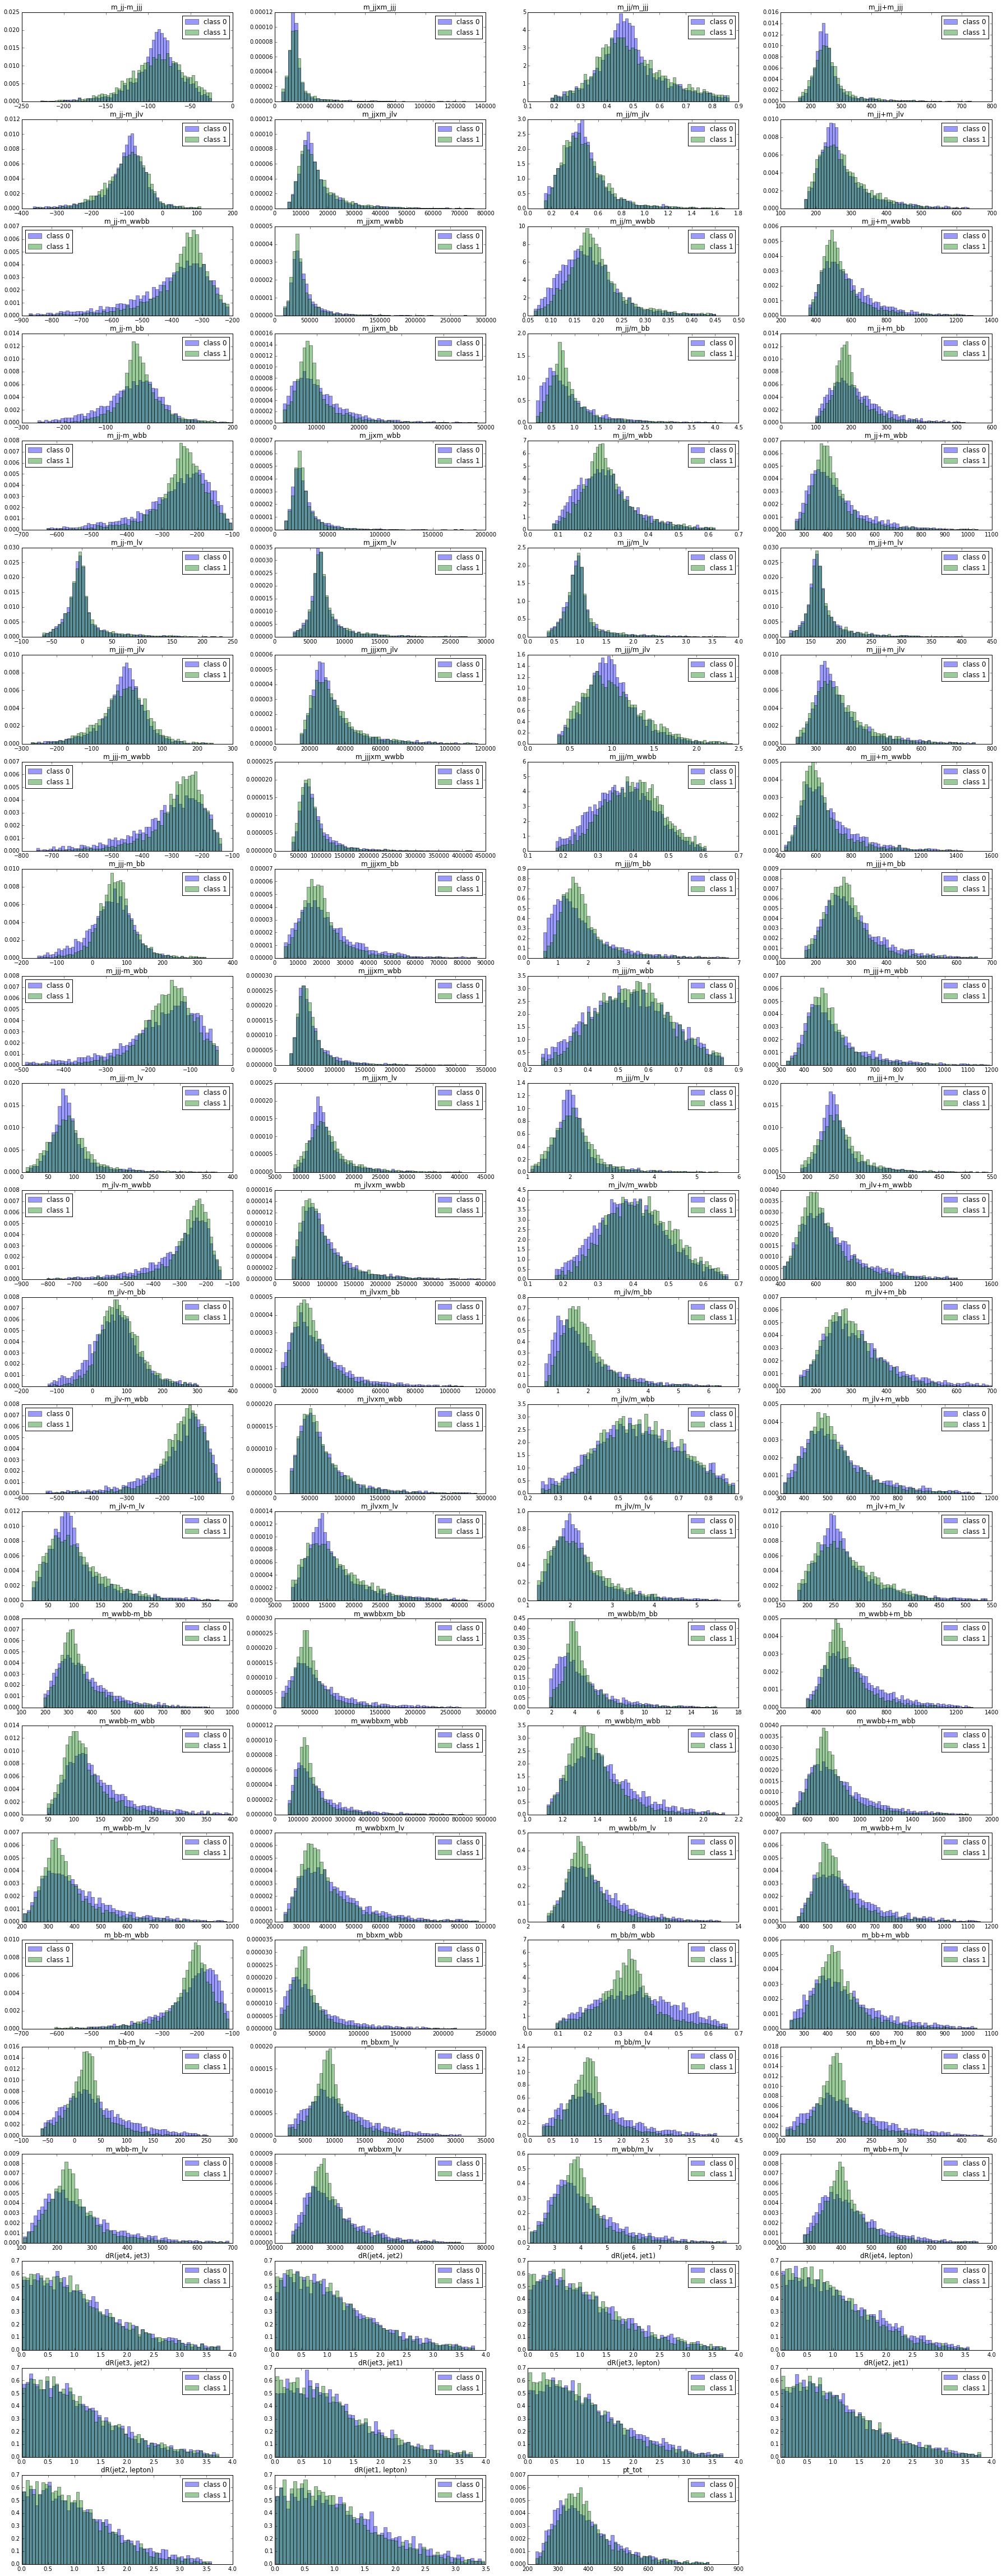

In [190]:
hist_params = {'normed': True, 'bins': 60, 'alpha': 0.4}
# create the figure
plt.figure(figsize=(31, 85))
for n, feature in enumerate(new_features):
    # add sub plot on our figure
    plt.subplot(25, 4, n+1)
    # define range for histograms by cutting 1% of data from both ends
    min_value, max_value = np.percentile(data[feature], [1, 99])
    plt.hist(data.ix[data.target.values == 0, feature].values, range=(min_value, max_value), 
             label='class 0', **hist_params)
    plt.hist(data.ix[data.target.values == 1, feature].values, range=(min_value, max_value), 
             label='class 1', **hist_params)
    plt.legend(loc='best')
    plt.title(feature)

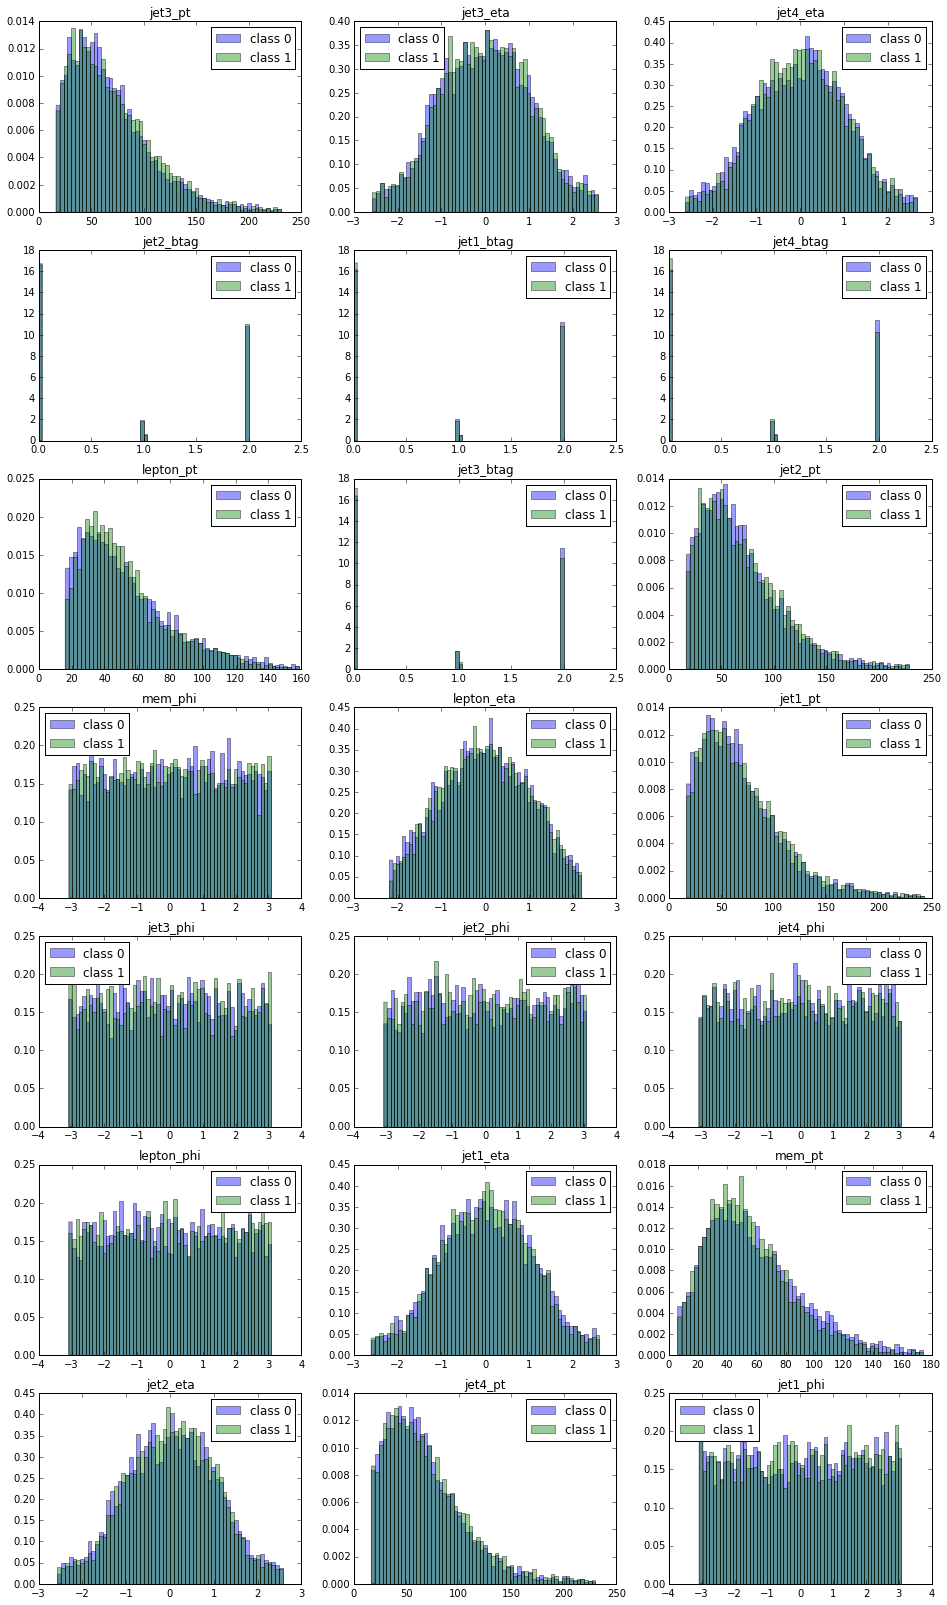

In [177]:
plt.figure(figsize=(16, 28))
for n, feature in enumerate(low_level_features):
    # add sub plot on our figure
    plt.subplot(7, 3, n+1)
    # define range for histograms by cutting 1% of data from both ends
    min_value, max_value = np.percentile(data[feature], [1, 99])
    plt.hist(data.ix[data.target.values == 0, feature].values, range=(min_value, max_value), 
             label='class 0', **hist_params)
    plt.hist(data.ix[data.target.values == 1, feature].values, range=(min_value, max_value), 
             label='class 1', **hist_params)
    plt.legend(loc='best')
    plt.title(feature)

## Simple knn from sklearn

In [9]:
knn_cv = cross_val_score(KNeighborsClassifier(n_neighbors=6),
                data[high_level_features],
                data["target"],
                cv=4, n_jobs=4, scoring="roc_auc")
print knn_cv.mean(), knn_cv.std()

0.721489324587 0.000947318341457


## RandomForrest

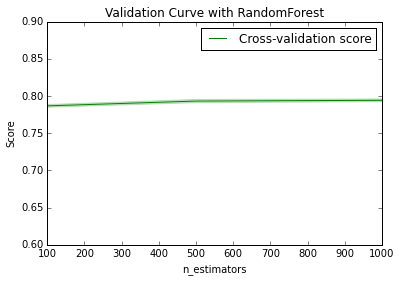

In [94]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.learning_curve import validation_curve
#rf_cv = cross_val_score(RandomForestClassifier(n_jobs=4, n_estimators=50),
#                        data[high_level_features],
#                        data["target"], scoring='roc_auc', cv=4)
#print rf_cv.mean(), rf_cv.std()
param_range = [100, 500,1000]
param_name = 'n_estimators'
train_scores, test_scores = validation_curve(RandomForestClassifier(n_jobs=4),
                                             data[features],
                                             data["target"], scoring='roc_auc', cv=4,
                                             param_name=param_name,
                                             param_range=param_range)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with RandomForest")
plt.xlabel(param_name)
plt.ylabel("Score")
plt.ylim(0.6, 0.9)
plt.plot(param_range, test_scores_mean, label="Cross-validation score",
             color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()


In [ ]:
clf.features_importances_
features
importance = pandas.Dataframe()
importance[0] = clf.features_importances_
importance.index = features
importance.plot(kind='barh')

In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
#clf = make_pipeline(PCA(), RandomForestClassifier(n_jobs=4, n_estimators=100))
clf = RandomForestClassifier(criterion='entropy', n_jobs=-1, n_estimators=100)
best_half = ['m_jj/m_wwbb',
 'm_wwbb',
 'm_jlv/m_wwbb',
 'm_wwbb-m_bb',
 'm_jjxm_bb',
 'dR(jet4, jet1)',
 'm_bbxm_wbb',
 'jet2_phi',
 'm_jlv-m_wwbb',
 'dR(jet3, jet2)',
 'm_jj/m_bb',
 'jet4_eta',
 'jet3_eta',
 'dR(jet2, jet1)',
 'm_jjjxm_jlv',
 'dR(jet4, jet2)',
 'jet4_phi',
 'm_jjj+m_lv',
 'm_jj-m_wbb',
 'lepton_eta',
 'mem_phi',
 'jet1_phi',
 'm_wbb+m_lv',
 'dR(jet4, jet3)',
 'dR(jet3, jet1)',
 'm_jlv/m_bb',
 'lepton_phi',
 'jet2_eta',
 'dR(jet1, lepton)',
 'jet3_phi',
 'jet1_eta',
 'm_jjj',
 'm_jjj-m_wwbb',
 'm_jjj/m_wwbb',
 'm_jj-m_wwbb',
 'm_jj/m_jjj',
 'm_jj+m_bb',
 'dR(jet4, lepton)',
 'dR(jet2, lepton)',
 'jet2_pt',
 'dR(jet3, lepton)',
 'm_bb/m_lv',
 'jet3_pt',
 'm_jjj-m_bb',
 'm_jjj/m_bb',
 'mem_pt',
 'jet1_pt',
 'jet4_pt',
 'lepton_pt',
 'm_wwbbxm_bb',
 'm_jj-m_jjj',
 'm_bb-m_lv',
 'm_wwbb/m_bb',
 'm_bbxm_lv',
 'm_jj-m_bb',
 'm_bb-m_wbb',
 'm_bb',
 'm_bb+m_lv',
 'pt_tot',
 'm_wwbb-m_wbb',
 'm_bb/m_wbb',
 'm_wwbb/m_wbb']

original_features = list(set(features) - set(new_features))
considered_features = new_features + high_level_features
rf_cv = cross_val_score(clf,
                        #data[considered_features],
                        #data[original_features],
                        #data[features],
                        data[best_half],
                        data["target"],
                        scoring='roc_auc',
                        cv=4)
print rf_cv.mean(), rf_cv.std()


0.772299136721 0.00160144048491


In [227]:
clf.fit(data[features], data["target"])
clf.feature_importances_
features
importance = pandas.DataFrame()
importance['importance'] = clf.feature_importances_
importance.index = features
importance.sort_values('importance', ascending=True, inplace=True)
importance.plot(kind='barh',figsize=(5,50))

ValueError: Length mismatch: Expected axis has 62 elements, new values have 124 elements

In [225]:
print importance.index.shape
list(importance.index[int(importance.index.shape[0]/2):])

(124,)


['m_jj/m_wwbb',
 'm_wwbb',
 'm_jlv/m_wwbb',
 'm_wwbb-m_bb',
 'm_jjxm_bb',
 'dR(jet4, jet1)',
 'm_bbxm_wbb',
 'jet2_phi',
 'm_jlv-m_wwbb',
 'dR(jet3, jet2)',
 'm_jj/m_bb',
 'jet4_eta',
 'jet3_eta',
 'dR(jet2, jet1)',
 'm_jjjxm_jlv',
 'dR(jet4, jet2)',
 'jet4_phi',
 'm_jjj+m_lv',
 'm_jj-m_wbb',
 'lepton_eta',
 'mem_phi',
 'jet1_phi',
 'm_wbb+m_lv',
 'dR(jet4, jet3)',
 'dR(jet3, jet1)',
 'm_jlv/m_bb',
 'lepton_phi',
 'jet2_eta',
 'dR(jet1, lepton)',
 'jet3_phi',
 'jet1_eta',
 'm_jjj',
 'm_jjj-m_wwbb',
 'm_jjj/m_wwbb',
 'm_jj-m_wwbb',
 'm_jj/m_jjj',
 'm_jj+m_bb',
 'dR(jet4, lepton)',
 'dR(jet2, lepton)',
 'jet2_pt',
 'dR(jet3, lepton)',
 'm_bb/m_lv',
 'jet3_pt',
 'm_jjj-m_bb',
 'm_jjj/m_bb',
 'mem_pt',
 'jet1_pt',
 'jet4_pt',
 'lepton_pt',
 'm_wwbbxm_bb',
 'm_jj-m_jjj',
 'm_bb-m_lv',
 'm_wwbb/m_bb',
 'm_bbxm_lv',
 'm_jj-m_bb',
 'm_bb-m_wbb',
 'm_bb',
 'm_bb+m_lv',
 'pt_tot',
 'm_wwbb-m_wbb',
 'm_bb/m_wbb',
 'm_wwbb/m_wbb']

original_features = 0.758 pm 0.006
high_level + pairwise = 0.757 pm 0.003
original + pairwise = 0.768 pm 0.002
original + pairwise + pt_sum = 0.77176178091 0.00295422620281
original + pairwise + pt_sum + dRs = 0.772226156557 0.00205566825336


In [232]:
! pip install -e git+git://github.com/fmfn/BayesianOptimization#egg=bayes_opt

Obtaining bayes-opt from git+git://github.com/fmfn/BayesianOptimization#egg=bayes_opt
  Cloning git://github.com/fmfn/BayesianOptimization to ./src/bayes-opt
  Running setup.py (path:/notebooks/higgs_kaggle/src/bayes-opt/setup.py) egg_info for package bayes-opt produced metadata for project name bayesian-optimization. Fix your #egg=bayes-opt fragments.
  Running setup.py develop for bayesian-optimization
You are using pip version 8.1.1, however version 8.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [6]:
from __future__ import print_function
from __future__ import division

from bayes_opt import BayesianOptimization
def rfccv(min_samples_split, max_depth, criterion):
    return cross_val_score(RandomForestClassifier(
            n_estimators=100,
            min_samples_split=int(min_samples_split),
            max_depth=int(max_depth),
            criterion=('gini' if criterion <= 0 else 'entropy'),),
                           data[best_half], scoring="roc_auc",
                           cv=4, n_jobs=4).mean()

rfcBO = BayesianOptimization(rfccv, {'min_samples_split': (1, 20),
                                     'max_depth': (1, 1000),
                                     'criterion': (-1, 1)})
rfcBO.maximize(init_points=10, n_iter=50)
print('-'*53)
print('Final Results')
print('RFC: %f' % rfcBO.res['max']['max_val'])

Initialization
-------------------------------------------------------------------------------
 Step |   Time |      Value |   criterion |   max_depth |   min_samples_split | 


ValueError: Expected array-like (array or non-string sequence), got None

## Best so far

In [228]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA, TruncatedSVD
#clf = make_pipeline(, RandomForestClassifier(n_jobs=4, n_estimators=100))
clf = RandomForestClassifier(criterion='entropy', n_jobs=-1, n_estimators=1000)
rf_cv = cross_val_score(clf,
                        #data[high_level_features],
                        #data[list(set(features) - set(new_features))],
                        #data[features],
                        data[best_half],
                        data["target"], scoring='roc_auc', cv=4)
print rf_cv.mean(), rf_cv.std()

0.779329106653 0.00122686742605


In [17]:
# predict test sample
kaggle_proba = knn.predict_proba(test[high_level_features])[:, 1]
kaggle_ids = test.event_id

In [18]:
from IPython.display import FileLink
def create_solution(ids, proba, filename='baseline.csv'):
    """saves predictions to file and provides a link for downloading """
    pandas.DataFrame({'event_id': ids, 'prediction': proba}).to_csv('datasets/{}'.format(filename), index=False)
    return FileLink('datasets/{}'.format(filename))
    
create_solution(kaggle_ids, kaggle_proba)

/Users/antares/Yandex.Disk.localized/projects/MLHEP/mlhep2016/higgs_kaggle/datasets/baseline.csv